# Simulation d'un hacheur

*Ecrit par Marc BUDINGER, INSA Toulouse*

Nous allons ici simuler un hacheur de contrôle moteur avec différents niveaux de fidélité et de représentativité.   

## Simulation d'un convertisseur DC/DC à découpage

Nous supposerons que le convertisseur est une cellule de commutation dans une configuration de hacheur dévolteur comme représenté dans la figure ci-dessous. La source de tension représente la batterie du véhicule, la charge RLE le moteur électrique à courant continu.

*Cellule de commmutation en [hacheur dévolteur](http://physiquenetappliquee.free.fr/hacheur.php)*  
![Hacheur dévolteur](./figures/hacheur_serie11.jpg)

> *Question :* Comment faut-il modifier ce convertisseur pour pouvoir réaliser du freinage récupératif ou une marche arrière ?

> *Exercice :* Simuler le fichier `HacheurPWM` du fichier [fourni](.modelica/Goupil_Hacheur.mo) et analyser les formes d'ondes en courant en en tension. 

*Modèle Modelica*  
![Hacheur](./figures/HacheurPWMModelica.PNG)


## Ondulation de courant

L'inductance du moteur limite l'ondulation du courant. Les figures suivantes représentent l'évolution transitoire des courants et des tensions au niveau de cette inductance.

*Evolution temporelle du courant*
![CurrentRipple](./figures/CurrentRipple.png)

> **Question:** Montrer que l'ondulation de courant peut être exprimées par la relations $\Delta I=\frac{E(1-\alpha)\alpha T}{L}$

> **Exercice :** Tracer l'évolution de l'ondulations de courant en fonction du rapport cyclique. Quel est le point de fonctionnement le plus critique ?   

Pour les calculs suivants, ce rapport cyclique critique sera supposé.


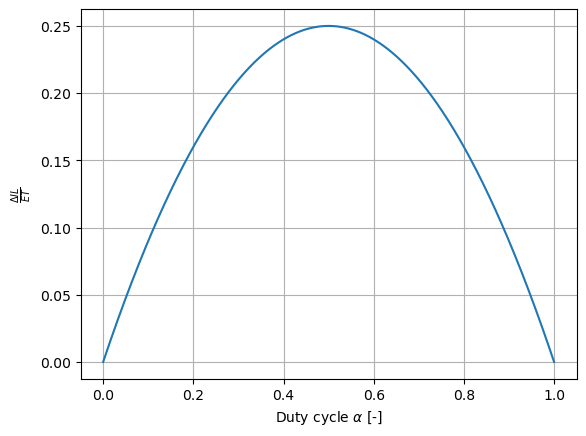

The critical duty cycle is: 0.50


In [5]:
import matplotlib.pyplot as plt
import numpy as np

alpha=np.linspace(0,1,1000)
ripple=alpha*(1-alpha)
plt.plot(alpha,ripple)  
plt.xlabel(r'Duty cycle $\alpha$ [-]')
plt.ylabel(r'$\frac{\Delta IL}{ET}$')
plt.grid()
plt.show()

print('The critical duty cycle is: %.2f'%(alpha[np.argmax(ripple)]))

> **Question :** Expliciter l'intérêt de l'ajout d'une inductance de filtrage dans la configuration simulée précédente. Proposer une valeur d'inductance permettant de limiter l'ondulation de courant à 10%. Vérifier par simulation.

*Inductance de [filtrage](https://www.circe-technologies.com/selfs-de-filtrage.html)*   
![Self de lissage](https://www.circe-technologies.com/media/4297/medium/self-de-filtrage.webp)


> **Question :** En amont de la cellule de commutation, il est nécessaire d'ajouter un condensateur afin de limiter l'ondulation de tension : $\Delta V=\frac{I_{max}(1-\alpha)\alpha T}{C}$. Proposer un valeur de capacité limitant l'ondulation de tension à 10%.


In [10]:
# Calcul de l'inductance et du condensateur

# Specification inductance
Inom=140 # [A] Courant nominal du moteur
E=48 # [V] Tension batterie
f=10e3 # [Hz] frequence de découpage
T=1/f # [s] période de découpage
DI_I=0.1 #  [-] Ondulation de courant normalisée

DI=DI_I*Inom # [A] Ondulation de courant 

# Calcul de l'inductance
L=E*(1-0.5)*0.5*T/DI

print("Inductance de filtrage : %.0f µH"%(L/1e-6))

# Specification capacité
DV_V = 0.1
DV=DV_V*E # [V] Ondulation de tension

# Calcul de la capacité 
C=Inom*(1-0.5)*0.5*T/DV

print("Capacité de filtrage : %.0f µF"%(C/1e-6))
print("Courant RMS dans le condensateur: %.1f A "%(((1-0.5)*0.5)**0.5*Inom))


Inductance de filtrage : 86 µH
Capacité de filtrage : 729 µF
Courant RMS dans le condensateur: 70.0 A 


## Modèle moyen de hacheur

La représentation temporelle du hachage de la tension implique un coût de calcul important car il est nécessaire de représenter finement chaque période de découpage. Il est souvent plus judicieux pour simuler des profils de mission mécanique d'utiliser un modèle moyen de convertisseur. 

> **Question :** Analyser les formes d'ondes et proposer une relation permettant de calculer la tension moyenne en sortie du hacheur. Completer la section *equation* du modèle `transfo_controlled` du fichier fourni. Tester ce modèle à l'aide du modèle `Hacheur_Mean`. 


## Calcul des pertes en conduction et commutation

Les pertes dans les composants de puissance, comme les IGBT ou les MOSFET, se répartissent principalement en pertes par conduction et pertes par commutation :

- **Pertes par conduction :** Elles se produisent lorsque le transistor est passant (ON). Elles sont dues à la résistance interne du composant (Rds(on) pour les MOSFET ou la tension Vce(sat) pour les IGBT). La puissance dissipée est fonction courant qui traverse le transistor :  
$P_{cond}=R_{ds(on)}I^2$ (MOSFET) ou $P_{cond}=V_{ce(sat)}I=V_0I+R_0I^2$ (IGBT).  


- **Pertes par commutation :** Elles surviennent lors du passage entre les états ON et OFF. Pendant ces transitions, la tension et le courant ne sont pas simultanément nuls, créant une dissipation énergétique. La puissance dissipée dépend de la fréquence de commutation, des temps de montée et de descente du signal, et des caractéristiques capacitives du transistor. La perte totale est donnée par :   
$P_{com}=1/2⋅V⋅I⋅(t_{rise}+t_{fall})f_{switch} = (E_{on}+E_{off})f_{switch}$  
, où $f_{switch}$ est la fréquence de commutation.


Le tableaux suivants synthétise les équations qui permettent de calculer les pertes dans le principaux composants du convertisseur.

*Grandeurs nécessaires aux calculs de pertes dans un convertisseur DC/DC*  

| | Inductance | IGBT  	| Diode  	| DC Capacitor |  
| :-: | :-:	| :-: | :-: | :-: |  
| Mean current | $I_L$ | $\alpha I_L$ | $(1-\alpha)I_L$ | 0 |    
| RMS current  	| $I_{L,RMS}$  	|  $\sqrt{\alpha } I_{L,RMS}$ 	|  $\sqrt{1-\alpha } I_{L,RMS}$ 	| $\sqrt{\alpha \left(1-\alpha \right)} I_{L,RMS}$  	|  
| Conduction losses   	|  $R_{L}I_{RMS}^{2}$ 	|  ${V_{0}}{I_{mean}}+R_{0}I_{RMS}^{2}$ 	| ${V_{0}}{I_{mean}}+R_{0}I_{RMS}^{2}$   	| $R_{S}I_{RMS}^{2}$  	|  
| Commutation losse  	|  0 	|  $f(E_{on}+E_{off})$ 	| $\frac{1}{8} f I_{RM} E t_{rr}$  	|  0 	|  



avec : $I_{L,RMS}=I_{L}\sqrt{1+\frac{1}{12}\left(\frac{\Delta I_{L}}{I_{L}}\right)^{2}}$

> **Question :** Expliquer commant les valeurs moyennes et RMS du courant ont été calculées. Rappeler les hypothèses de calculs liant ces formules à l'explication des pertes du début du paragraphe.

> **Exercice :** Analyser le modèle `Hacheur_Mean_Losses`. Paramétrer le modèle avec les informations disponibles dans les documents constructeurs : [Transistor MOS](https://www.arcel.fr/fr/transistors-mosfet/725-IXFN420N10T.html), [DC capacitor](https://www.tdk-electronics.tdk.com/inf/20/50/ds/B2562_.pdf) et l'annexe sur l'[inductance](./A3_Inductor.ipynb).

*Simulation du profil de pertes du convertisseur DC/DC*   
![Hacheur avec pertes](./figures/HacheurMean_Losses.PNG)


**Remarques** : bien prendre garde au courant maximal efficace ou RMS que peut supporter le condensateur dénommé $Imax$ dans le datasheet (Maximum rms current for continuous operation for the given frequency range and for the maximum ripple voltage).


